# Sampling Soft Measurements

This notebook shows how to generate synthetic soft measurement samples from the read-out of superconducting and neutral atom qubits using the `soft_information_models` Python library. The notebook is split in three sections:
1) Superconducting qubit readout model
2) Neutral atom qubit readout model
3) Generating soft measurement samples from a STIM circuit

For additional context around the work, please refer to our [arXiv pre-print](https://arxiv.org/abs/2504.03504).

## 1) Superconducting qubit measurement model

To represent the measurement response of superconducting qubits, we use the dispersive readout model by [Pattison et al.](https://arxiv.org/abs/2107.13589). Upon measurement, a resonator coupled to the qubit exhibits a dispersive shift $\mu$ (the soft measurement response) that depends on the state of the qubit. In a simplified one-dimensional picture, we have a probability density function (PDF) $P(\mu |0)$ for the $\ket{0}$-state that is centred at $\mu = +1$ and another probability density function $P(\mu |1)$ for the $\ket{1}$-state centred at $\mu = -1$. Both PDFs are Gaussians in an ideal case, but due to $T_1$-processes, the measurement response experiences amplitude damping, i.e. transitions from the excited state $\ket{1}$ down to the ground state $\ket{0}$ at a specific rate $\beta$. The shape of these two measurement PDFs is captured in the `SuperconductingPDF` class, which we use to sample soft measurements.

We begin by importing the PDF for superconducting qubits, as well as the `numpy` and `matplotlib` libraries for analysis and plotting:

In [1]:
from soft_information_models import SuperconductingPDF
import matplotlib.pyplot as plt
import numpy as np

Next, we plot the values of a superconducting PDF with signal-to-noise ratio $\textrm{SNR} = 10$ and amplitude damping parameter $\beta=1$. A value of $\beta=1$ is far higher than seen in realistic devices, we merely choose it here to illustrate the presence of $T_1$ processes. These parameters define a target probability distribution from which we will sample soft measurements.

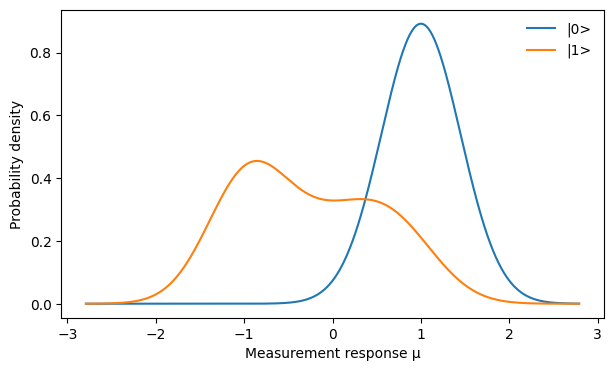

In [2]:
SNR = 10
BETA = 1
pdf = SuperconductingPDF(snr=SNR, beta=BETA)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
domain = pdf._domain
eval_0 = pdf._0_state_values
eval_1 = pdf._1_state_values
ax.plot(domain, eval_0, label='|0>')
ax.plot(domain, eval_1, label='|1>')
ax.set_xlabel("Measurement response μ")
ax.set_ylabel("Probability density")
plt.legend(loc='upper right', frameon=False)
plt.show()

Now that we know our target distribution, we show how to sample random soft measurement values $\mu$ from it. In the `SuperconductingPDF` class, this can be done via the `sample()` method, as shown below. Comparing the soft measurement samples against the target distribution, we see that the two are in good agreement.

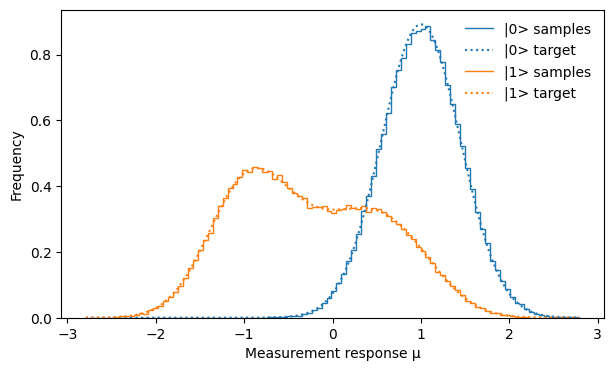

In [3]:
# generate 100k samples from 0-state distribution
zero_samples = pdf.sample(np.zeros(100_000))

# generate 100k samples from 1-state distribution
one_samples = pdf.sample(np.ones(100_000))

# plot histogram of the resulting samples vs the target distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
bins = np.linspace(min(one_samples), max(zero_samples), 100)
zero_counts, _ = np.histogram(zero_samples, bins=bins, density=True)
one_counts, _ = np.histogram(one_samples, bins=bins, density=True)
ax.stairs(zero_counts, bins, label='|0> samples', color='C0')
ax.plot(domain, eval_0, label='|0> target', linestyle='dotted', color='C0')
ax.stairs(one_counts, bins, label='|1> samples', color='C1')
ax.plot(domain, eval_1, label='|1> target', linestyle='dotted', color='C1')
ax.set_xlabel("Measurement response μ")
ax.set_ylabel("Frequency")
plt.legend(loc='upper right', frameon=False)
plt.show()

For soft decoding, we are interested in the ratio of the two probability density functions $P(\mu |0)$ and $P(\mu |1)$. This can be efficiently captured in the posterior probabilities $\textrm{post}_1(\mu)$ and $\textrm{post}_0(\mu)$ for some given soft measurement $\mu$, as calculated from

$$ \textrm{post}_0(\mu) = P(0|\mu) = \frac{P(\mu |0)}{P(\mu |0) + P(\mu |1)}$$

$$\textrm{post}_1(\mu) = P(1|\mu) =\frac{P(\mu |1)}{P(\mu |0) + P(\mu |1)}$$

where we have assumed that on average, the prior probabilities $P(0) = P(1)$.

Below, we plot the posterior measurement probabilities conditional on a soft outcome $\mu$, showing the region $P(0 \mid \mu) = P(1 \mid \mu)$ where measurements are maximally uncertain. The posterior probabilities are obtained from the `SuperconductingPDF` class via the `predict_p()` method.

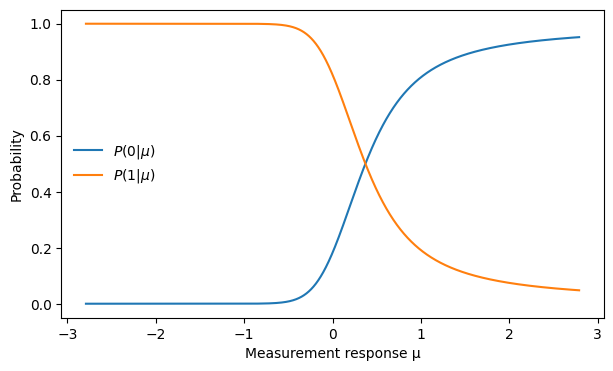

In [4]:
p_meas = pdf.predict_p(domain)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(domain, p_meas[:, 0], label='$P(0|\mu)$')
ax.plot(domain, p_meas[:, 1], label='$P(1|\mu)$')
ax.legend(loc='center left', frameon=False)
ax.set_xlabel("Measurement response μ")
ax.set_ylabel("Probability")
plt.show()

For decoding purposes, we do not need the absolute values of $P(\mu |0)$ and $P(\mu |1)$, as the decoder only accepts the posterior probabilities $\textrm{post}_1(\mu)$ and $\textrm{post}_0(\mu)$. To sample these efficiently, the `SuperconductingPDF` class allows for direct sampling of representative posterior measurement probabilities based on the ideal state 0 or 1. This is accomplished using the `sample_p()` method, and we show what the resulting probability distribution looks like below:

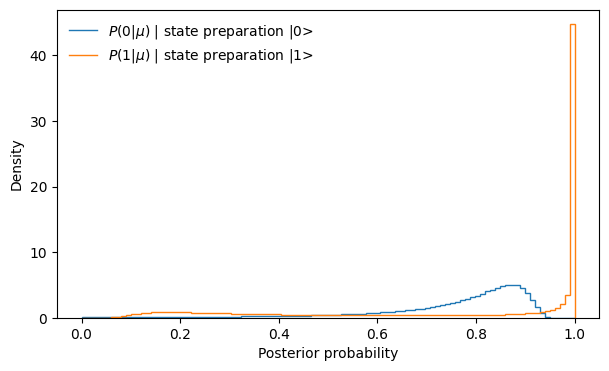

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
bins = np.linspace(0, 1, 100)
for i in range(2):
    ideal_outcomes = i * np.ones(1_000_000)
    samples = pdf.sample_p(ideal_outcomes)
    counts_i, _ = np.histogram(samples[:, i], bins=bins, density=True)
    ax.stairs(counts_i, bins, label=f'$P({i}|\mu)$ | state preparation |{i}>', linestyle='solid')
ax.set_xlabel('Posterior probability')
ax.set_ylabel('Density')
ax.legend(loc='upper left', frameon=False)
plt.show()

## 2) Neutral atom qubit measurement model

For neutral atoms, our measurement model is based on non-destructive fluorescence-based readout, as described in [PhysRevA.108.032407](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.032407) and [PhysRevA.102.053101](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.053101). The measurement response of a neutral atom qubit is in the form of a photon count $\mu$ captured by a photodetector. For a qubit in the $\ket{0}$-state, there is minimal emission, referred to as a _dark state_, while a $\ket{0}$-state has high emission, referred to as a _bright state_, allowing for the two states to be distinguished based on the number of photons emitted. Due to background scattering, $\ket{0}\rightarrow \ket{1}$ and $\ket{1}\rightarrow \ket{0}$ transitions, imperfect detection efficiency and the Poissonian nature of photon emission, there exists an overlap between the distributions $P(\mu |0)$ and $P(\mu |1)$ which can lead to measurement classification errors.

In our model, encoded in the `NeutralAtomPDF` class, we can simulate soft measurement samples from the photon counts of $\ket{0}$- and $\ket{1}$-state measurements. In the example below, we plot the two state-based measurement PDFs for a realistic neutral atom qubit measurement model with the following parameters:
- Detection efficiency $\eta\in[0, 1]$
- Measurement time $\tau_M$
- Bright-state scattering rate $R_0$
- Background scattering rate $R_{bg}$
- Bright-to-dark state transition rate $R_{b \rightarrow d}$
- Dark-to-bright state transition rate $R_{d \rightarrow b}$

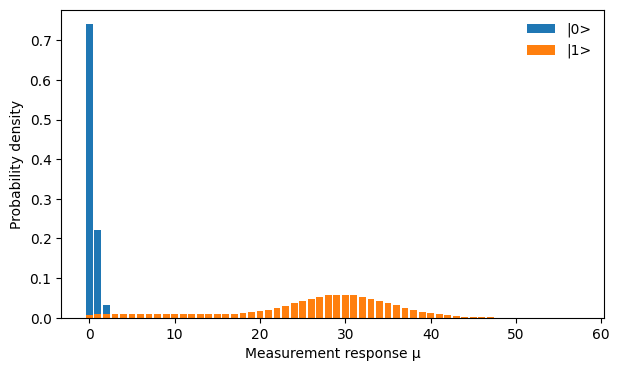

In [6]:
from soft_information_models import NeutralAtomPDF

pdf = NeutralAtomPDF(
    detection_efficiency=0.01,
    t_measurement=300e-6,
    rate_bright_scatter=1e7,
    rate_background_scatter=1e3,
    rate_bright_to_dark=0.96e3,
    rate_dark_to_bright=2,
)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
domain = pdf._domain
eval_0 = pdf._0_state_values
eval_1 = pdf._1_state_values
ax.bar(domain, eval_0, label='|0>')
ax.bar(domain, eval_1, label='|1>')
ax.set_xlabel("Measurement response μ")
ax.set_ylabel("Probability density")
plt.legend(loc='upper right', frameon=False)
plt.show()

In the plot above, we see how the bright $\ket{1}$-state exhibits significantly higher photon counts $\mu$ than the dark state $\ket{0}$. There remains some overlap between the two distributions at low $\mu$, which results in measurement classification errors. Sinilarly to the superconducting case, we can look at the posterior probabilities $\textrm{post}_0(\mu)$ and $\textrm{post}_1(\mu)$ for the neutral atom PDF via the `predict_p()` method, as shown below.

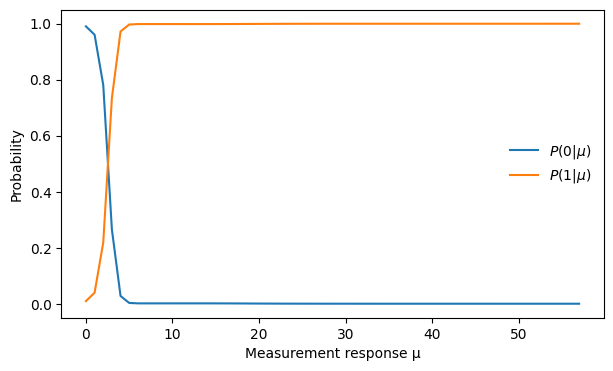

In [7]:
p_meas = pdf.predict_p(domain)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(domain, p_meas[:, 0], label='$P(0|\mu)$')
ax.plot(domain, p_meas[:, 1], label='$P(1|\mu)$')
ax.legend(loc='center right', frameon=False)
ax.set_xlabel("Measurement response μ")
ax.set_ylabel("Probability")
plt.show()

Similar to the superconducting case, we can directly sample measurement probabilities from a `NeutralAtomPDF` class via the `sample_p()` method, as below. Due to the discrete nature of the measurement distribution, the resulting probabilities are clustered in fixed locations.

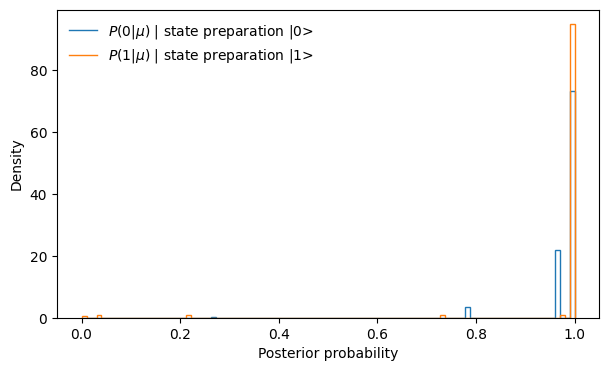

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
bins = np.linspace(0, 1, 100)
for i in range(2):
    ideal_outcomes = i * np.ones(1_000_000)
    samples = pdf.sample_p(ideal_outcomes)
    counts_i, _ = np.histogram(samples[:, i], bins=bins, density=True)
    ax.stairs(counts_i, bins, label=f'$P({i}|\mu)$ | state preparation |{i}>', linestyle='solid')
ax.set_xlabel('Posterior probability')
ax.set_ylabel('Density')
ax.legend(loc='upper left', frameon=False)
plt.show()

## 3) Generating soft measurement samples from a STIM circuit

To sample measurements from QEC cirsuits, we leverage the fast Clifford simulator [STIM](https://doi.org/10.22331/q-2021-07-06-497) - available as a Python [library](https://github.com/quantumlib/Stim). In this section, we show how to use the output from a STIM circuit as the basis for soft measurement sampling, and how to discretise the resulting measurement probabilities into a desired bit depth. To start with, we import `stim` and read in a pre-generated QEC circuit. The example circuit contains three rounds of stabiliser measurements for a distance-3 rotated planar surface code, and contains error channels from a superconducting-informed noise model.

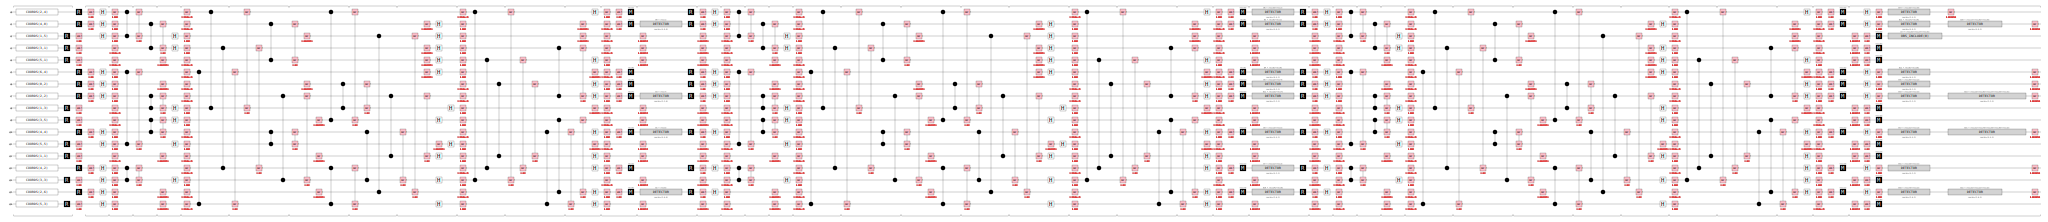

In [9]:
import stim
circuit = stim.Circuit.from_file("example.stim")
circuit.diagram('timeline-svg')

Given the above circuit, we sample measurements from it. These measurements are the "ideal outcomes" $\bar{\mu}=0$ and $\bar{\mu}=1$ which determine whether a soft measurement is sampled from $P(\mu |0)$ or $P(\mu |1)$.

In [10]:
num_shots = 1
sampler = stim.CompiledMeasurementSampler(circuit)
ideal_outcomes = sampler.sample(num_shots)
print(f"Ideal outcomes:\n\n {np.array(ideal_outcomes[0], dtype=np.uint8).tolist()}")

Ideal outcomes:

 [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]


Given a vector of ideal measurement outcomes, we can sample soft measurement probabilities from either `SuperconductingPDF` or `NeutralAtomPDF` using the `sample_p()` method. Below, we use the neutral atom PDF defined previously to sample soft measurement probabilities $\textrm{post}_1(\mu)$ given the ideal measurement outcomes $\bar{\mu}$ from STIM.

In [11]:
posterior_1 = pdf.sample_p(ideal_outcomes.flatten())[:, 1]
print(f"post_1:\n\n {np.round(posterior_1, 3).T.tolist()}\n")

post_1:

 [1.0, 1.0, 1.0, 0.999, 1.0, 0.009, 0.009, 0.039, 0.999, 1.0, 1.0, 1.0, 0.009, 0.039, 0.039, 1.0, 1.0, 1.0, 1.0, 0.039, 0.039, 0.009, 0.009, 0.009, 0.009, 0.999, 1.0, 0.009, 0.009, 0.039, 1.0, 0.999, 0.999]



For soft decoding, 8 bits of measurement probability are sufficient to retain accuracy, as found by [Hanisch et al](https://arxiv.org/abs/2411.16228). We can truncate the measurement probabilities into 8 bits as shown below.

In [12]:
p_1_uint8s = np.array(np.round(255 * np.reshape(posterior_1, ideal_outcomes.shape)), dtype=np.uint8)

print(f"8-bit posterior probability post_1: {p_1_uint8s.tolist()}")

8-bit posterior probability post_1: [[255, 255, 255, 255, 255, 2, 2, 10, 255, 255, 255, 255, 2, 10, 10, 255, 255, 255, 255, 10, 10, 2, 2, 2, 2, 255, 255, 2, 2, 10, 255, 255, 255]]


To get a hard measurement outcome from the soft samples, we simply threshold the measurement probabilities at $P=1/2$. In the 8-bit representation, this is equivalent to checking if the value of the measurement probability is greater than 127.

In [13]:
hardened_measurements = np.array((p_1_uint8s > 127), dtype=np.uint8)
print(f"Hardened measurement outcomes: {hardened_measurements.tolist()}")

Hardened measurement outcomes: [[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]]


We can see the ideal measurements and hardened measurement outcomes are not identical. This is due to the classification errors that were introduced in the measurement process.

In [14]:
num_meas = hardened_measurements.size
print(f"Due to soft measurement errors, {np.sum(hardened_measurements != ideal_outcomes)} out of {num_meas} measurement outcomes were flipped.")

Due to soft measurement errors, 0 out of 33 measurement outcomes were flipped.
